In [1]:
!pip install keras
!pip install matplotlib
!pip install numpy
!pip install opencv-python
!pip install opencv-contrib-python==3.4.2.17
!pip install pandas
!pip install pillow
!pip install scikit-learn
!pip install scikit-image
!pip install scikit-optimize
!pip install shortuuid
!pip install tensorflow-gpu
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-y8g19t8i
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-y8g19t8i
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0-py3-none-any.whl size=84100 sha256=ceb7c0c54a8c6d2501c631ed0ebc6ad65a338a6e3884a2db0ecf323f558558a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-b_uzcjdi/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [7]:
import copy
import csv
import glob
import pathlib
import os
import re
import shutil
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shortuuid
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

from collections import Counter
from datetime import timedelta
from IPython.display import display
from PIL import Image
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator


np.set_printoptions(precision=4)

# Get reproducible results
random_state = 46
np.random.seed(random_state)
tf.random.set_seed(random_state)


def ann_file(data_dir):
    return os.path.join(data_dir, "TrainAnnotations.csv")


TRAIN_DATA_DIR = "data/TrainData-C1"
TRAIN_DATA_ANN_FILE = ann_file(TRAIN_DATA_DIR)

TRAIN_SPLIT_DATA_DIR           = "data-c1/train/split"
TRAIN_SPLIT_ANN_FILE           = ann_file(TRAIN_SPLIT_DATA_DIR)
TRAIN_SPLIT_AUGMENTED_DATA_DIR = "data-c1/train/augmented"
TRAIN_SPLIT_AUGMENTED_ANN_FILE = ann_file(TRAIN_SPLIT_AUGMENTED_DATA_DIR)
TRAIN_SPLIT_PATCHES_DATA_DIR   = "data-c1/train/patches"
TRAIN_SPLIT_PATCHES_ANN_FILE   = ann_file(TRAIN_SPLIT_PATCHES_DATA_DIR)

TRAIN_ALL_AUGMENTED_DATA_DIR   = "data-c1/train-all/augmented"
TRAIN_ALL_AUGMENTED_ANN_FILE   = ann_file(TRAIN_ALL_AUGMENTED_DATA_DIR)
TRAIN_ALL_PATCHES_DATA_DIR     = "data-c1/train-all/patches"
TRAIN_ALL_PATCHES_ANN_FILE     = ann_file(TRAIN_ALL_PATCHES_DATA_DIR)

VAL_SPLIT_DATA_DIR         = "data-c1/val/split"
VAL_SPLIT_ANN_FILE         = ann_file(VAL_SPLIT_DATA_DIR)
VAL_SPLIT_PATCHES_DATA_DIR = "data-c1/val/patches"
VAL_SPLIT_PATCHES_ANN_FILE = ann_file(VAL_SPLIT_PATCHES_DATA_DIR)

TEST_DATA_DIR         = "data/TestData/"
TEST_PATCHES_DATA_DIR = "data/test/patches"

# Keras ImageDataGenerator expects that files are in a subdirectory
TEST_PATCHES_GEN_DATA_DIR = os.path.join(TEST_PATCHES_DATA_DIR, "test")

## GPU configuration
If you have a GPU, enable experimental memory growth.

In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Split data
Generate random, stratified 80/20 split for training and validation sets

In [186]:
if (os.path.exists(TRAIN_SPLIT_DATA_DIR) or os.path.exists(VAL_SPLIT_DATA_DIR)):
    print("Data directories for splits already exist. Skipping")
else:
    # Generate 80/20 split

    print("Reading {} annotations...".format(TRAIN_DATA_ANN_FILE))
    ann_df = pd.read_csv(TRAIN_DATA_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})

    print("Splitting data into training and validation sets...")
    train_df, val_df = train_test_split(ann_df,
                                        train_size=0.80,
                                        random_state=138,
                                        shuffle=True,
                                        stratify=ann_df[['annotation']].to_numpy(dtype=np.int32).flatten())

    os.makedirs(TRAIN_SPLIT_DATA_DIR)
    os.makedirs(VAL_SPLIT_DATA_DIR)
    
    print("Copying files for training split...")
    for _, row in train_df.iterrows():
        filename = row['file_name']
        src = os.path.join(TRAIN_DATA_DIR, filename)
        dest = os.path.join(TRAIN_SPLIT_DATA_DIR, filename)
        shutil.copyfile(src, dest)
        
    print("Generating training split annotations...")
    train_df.sort_values('file_name').to_csv(TRAIN_SPLIT_ANN_FILE, index=False)
        
    print("Copying files for validation split...")
    for _, row in val_df.iterrows():
        filename = row['file_name']
        src = os.path.join(TRAIN_DATA_DIR, filename)
        dest = os.path.join(VAL_SPLIT_DATA_DIR, filename)
        shutil.copyfile(src, dest)
        
    print("Generating validation split annotations...")
    val_df.sort_values('file_name').to_csv(VAL_SPLIT_ANN_FILE, index=False)
        
    print("Done.")

Data directories for splits already exist. Skipping


## Augment data
Because the training dataset is unbalanced, augment the training data set by generating
new images for the lower numbered samples.

In [9]:
DESIRED_CLASS_SAMPLE_COUNT = 400
RANDOM_STATE = 13

IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
PATCH_ROWS = 5
PATCH_COLUMNS = 5


def is_image_file(filename):
    return filename.endswith(IMG_EXTENSIONS)


def augment_data(src_dir, src_ann_file, dest_dir, dest_ann_file, class_sample_count=500):
    os.makedirs(dest_dir)

    ann_df = pd.read_csv(src_ann_file, dtype={'file_name': 'object', 'annotation': 'category'}) 
    new_samples = {}
    
    for i in range(5):
        class_df = ann_df.query("annotation == '{}'".format(i))
        num_class_samples = class_df.shape[0]
        num_to_create = class_sample_count - num_class_samples
            
        print("Creating {} images for class {}".format(num_to_create, i))
        samples = class_df.sample(n=num_to_create, replace=True, random_state=RANDOM_STATE)
    
        for idx, row in samples.iterrows():
            new_filename = row['file_name'].split('.')[0] + "_" + shortuuid.uuid() + ".png"
    
            # Apply transformations to each randomly selected sample
            img = Image.open(src_dir + "/" + row['file_name'])
            image_transforms = transforms.Compose([
                #transforms.RandomAffine(degrees=20, translate=(0.2, 0.2)),
                #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                #transforms.RandomResizedCrop((480, 640), scale=(1.0, 1.2)),
                
                transforms.RandomRotation((90,90), expand=True),
                transforms.RandomVerticalFlip(),
                transforms.RandomHorizontalFlip()
            ])
            transformed_img = image_transforms(img)
            transformed_img.save(os.path.join(dest_dir, new_filename))
    
            new_samples[new_filename] = row['annotation']
    
    # Add to new dataframe
    balanced_df = pd.read_csv(src_ann_file, dtype={'file_name': 'object', 'annotation': 'category'})
    balanced_df = balanced_df.append(pd.DataFrame.from_records([(k, v) for k, v in new_samples.items()],
                                                 columns=['file_name', 'annotation']))
    
    # Write new annotations
    balanced_df.sort_values('file_name').to_csv(dest_ann_file, index=False)
    
    # Copy images from training data split
    for file in glob.glob(src_dir + "/*"):
        if is_image_file(file):
            shutil.copy(file, os.path.join(dest_dir, os.path.basename(file)))


def generate_image_patches(img, rows, cols):
    """
    Generates a list of in-memory image overlapping patches
    
    Args:
        rows - number of rows of patchs to cover the height of the image
        cols - number of colums of patches to cover the width of the image
    """
    patches = []
    sizeX = img.shape[1]
    sizeY = img.shape[0]
    
    patch_sizeX = 224
    patch_sizeY = 224
    patch_relative_centerX = 112
    patch_relative_centerY = 112

    for i in range(0,rows):
        for j in range(0, cols):
            center = (patch_relative_centerX + (sizeX - patch_sizeX)/(rows - 1)*i, 
                      patch_relative_centerY + (sizeY - patch_sizeY)/(cols - 1)*j)
            patches.append(cv2.getRectSubPix(img, (patch_sizeX, patch_sizeY), center))
            
    return patches


def generate_patch_files(in_dir, out_dir, rows, cols):
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    images = [f for f in os.listdir(in_dir) if os.path.isfile(os.path.join(in_dir, f)) and is_image_file(f)]   
    for im in images:
        img = cv2.imread(os.path.join(in_dir, im))
        patches = generate_image_patches(img, rows, cols)
        
        for i in range(0,rows):
            for j in range(0, cols):
                patch = patches[i*rows + j]
                patch_name = im.split('.')[0] + '_' + str(i) + '_' + str(j) + '.png'
                cv2.imwrite(out_dir + '/' + patch_name, patch)


def generate_patch_annotations_df(df, rows, cols):
    patches_ann = {}
    
    for ind in df.index: 
        file_name = df['file_name'][ind]
        annotation = df['annotation'][ind]
        
        for i in range(0, rows):
            for j in range(0, cols):
                patch_name = file_name.split('.')[0] + '_' + str(i) + '_' + str(j) + '.png'
                patches_ann[patch_name] = annotation
    
    return pd.DataFrame.from_records([(k, v) for k, v in patches_ann.items()], 
                                     columns=['file_name', 'annotation'])


### Run data augmentation

Perform the data augmentation on the training data set split to balance the class samples.

In [188]:
if os.path.exists(TRAIN_SPLIT_AUGMENTED_DATA_DIR):
    print("Augmented SPLIT training data already exists. Skipping.")
else:
    print("Balancing class samples for SPLIT training data...")
    augment_data(TRAIN_SPLIT_DATA_DIR,
                 TRAIN_SPLIT_ANN_FILE,
                 TRAIN_SPLIT_AUGMENTED_DATA_DIR,
                 TRAIN_SPLIT_AUGMENTED_ANN_FILE,
                 class_sample_count=400)    
    print("Done.")

if os.path.exists(TRAIN_ALL_AUGMENTED_DATA_DIR):
    print("Augmented ALL training data already exists. Skipping.")
else:
    print("Balancing class samples for ALL training data...")
    augment_data(TRAIN_DATA_DIR,
                 TRAIN_DATA_ANN_FILE,
                 TRAIN_ALL_AUGMENTED_DATA_DIR,
                 TRAIN_ALL_AUGMENTED_ANN_FILE,
                 class_sample_count=500)
    print("Done.")

Augmented SPLIT training data already exists. Skipping.
Augmented ALL training data already exists. Skipping.


## Generate Patches

In [217]:
# SPLIT train patches
if os.path.exists(TRAIN_SPLIT_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(TRAIN_SPLIT_PATCHES_DATA_DIR))
else:
    print("Generating SPLIT training data patches...")
    generate_patch_files(TRAIN_SPLIT_AUGMENTED_DATA_DIR, TRAIN_SPLIT_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)

    print("Generating SPLIT training patch data annotations...")
    image_df = pd.read_csv(TRAIN_SPLIT_AUGMENTED_ANN_FILE)
    patch_annotations_df = generate_patch_annotations_df(image_df, PATCH_ROWS, PATCH_COLUMNS)
    patch_annotations_df.sort_values('file_name').to_csv(TRAIN_SPLIT_PATCHES_ANN_FILE, index=False)
    
# SPLIT val patches
if os.path.exists(VAL_SPLIT_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(VAL_SPLIT_PATCHES_DATA_DIR))
else:
    print("Generating SPLIT validation data patches...")
    generate_patch_files(VAL_SPLIT_DATA_DIR, VAL_SPLIT_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)

    print("Generating SPLIT validation patch data annotations...")
    image_df = pd.read_csv(VAL_SPLIT_ANN_FILE)
    patch_annotations_df = generate_patch_annotations_df(image_df, PATCH_ROWS, PATCH_COLUMNS)
    patch_annotations_df.sort_values('file_name').to_csv(VAL_SPLIT_PATCHES_ANN_FILE, index=False)

# test patches
if os.path.exists(TEST_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(TEST_PATCHES_DATA_DIR))
else:
    print("Generating test data patches...")
    generate_patch_files(TEST_DATA_DIR, TEST_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)
    
# ALL train patches
if os.path.exists(TRAIN_ALL_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(TRAIN_ALL_PATCHES_DATA_DIR))
else:
    print("Generating ALL train data patches...")
    generate_patch_files(TRAIN_ALL_AUGMENTED_DATA_DIR, TRAIN_ALL_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)

    print("Generating ALL training patch data annotations...")
    image_df = pd.read_csv(TRAIN_ALL_AUGMENTED_ANN_FILE)
    patch_annotations_df = generate_patch_annotations_df(image_df, PATCH_ROWS, PATCH_COLUMNS)
    patch_annotations_df.sort_values('file_name').to_csv(TRAIN_ALL_PATCHES_ANN_FILE, index=False)

print("Done.")

data-c1/train/patches exists. Skipping.
data-c1/val/patches exists. Skipping.
data/test/patches exists. Skipping.
Generating ALL train data patches...
Generating ALL training patch data annotations...
Done.


In [10]:
class SoybeanDataGroup():
    def __init__(self, class_weights, 
                 train_generator,
                 train_prediction_generator,
                 val_generator=None,
                 val_prediction_generator=None,
                 test_generator=None,
                 train_patch_ann_df=None,
                 val_patch_ann_df=None,
                 train_whole_image_ann_df=None,
                 val_whole_image_ann_df=None):
        self.class_weights = class_weights
        self.train_generator = train_generator
        self.train_prediction_generator = train_prediction_generator
        self.val_generator = val_generator
        self.val_prediction_generator = val_prediction_generator
        self.test_generator = test_generator
        self.train_patch_ann_df = train_patch_ann_df
        self.val_patch_ann_df = val_patch_ann_df
        self.train_whole_image_ann_df = train_whole_image_ann_df
        self.val_whole_image_ann_df = val_whole_image_ann_df

In [11]:
def train_val_split_group(class_weights=None):
    
    train_whole_image_ann_df = pd.read_csv(TRAIN_SPLIT_AUGMENTED_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    val_whole_image_ann_df   = pd.read_csv(VAL_SPLIT_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    print("Reading annotations...")
    train_ann_df = pd.read_csv(TRAIN_SPLIT_PATCHES_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    val_ann_df   = pd.read_csv(VAL_SPLIT_PATCHES_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    if class_weights is None:
        print("Computing class weights...")
        class_weights = compute_class_weights(train_ann_df, 'annotation')
        print(class_weights)
    else:
        print("Using class weights:", class_weights)
        
        
    data_gen_args = dict(
        preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
        #rotation_range=10,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #horizontal_flip=True
    )
    train_datagen = ImageDataGenerator(**data_gen_args)
    val_datagen = ImageDataGenerator(**data_gen_args)


    print("Defining train data generator...")
    train_generator = train_datagen.flow_from_dataframe(
            dataframe=train_ann_df,
            directory=TRAIN_SPLIT_PATCHES_DATA_DIR,
            x_col="file_name",
            y_col="annotation",
            batch_size=BATCH_SIZE,
            class_mode='sparse',
            target_size=(224,224)
    )
    
    train_prediction_generator = train_datagen.flow_from_dataframe(
            dataframe=train_ann_df,
            directory=TRAIN_SPLIT_PATCHES_DATA_DIR,
            x_col="file_name",
            batch_size=BATCH_SIZE,
            class_mode=None,
            shuffle=False,
            target_size=(224,224)
    )
    
    print("Defining validation data generator...")
    val_generator = val_datagen.flow_from_dataframe(
            dataframe=val_ann_df,
            directory=VAL_SPLIT_PATCHES_DATA_DIR,
            x_col="file_name",
            y_col="annotation",
            batch_size=BATCH_SIZE,
            class_mode='sparse',
            target_size=(224,224)
    )
    
    
    val_prediction_generator = val_datagen.flow_from_dataframe(
            dataframe=val_ann_df,
            directory=VAL_SPLIT_PATCHES_DATA_DIR,
            x_col="file_name",
            batch_size=BATCH_SIZE,
            class_mode=None,
            shuffle=False,
            target_size=(224,224)
    )
        
    test_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.vgg16.preprocess_input
    )

    test_generator = test_datagen.flow_from_directory(
        directory=TEST_PATCHES_DATA_DIR,
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=False,
        target_size=(224,224)
    )
    
    return SoybeanDataGroup(class_weights, 
                            train_generator,
                            train_prediction_generator,
                            val_generator, 
                            val_prediction_generator,
                            test_generator,
                            train_ann_df,
                            val_ann_df,
                            train_whole_image_ann_df, 
                            val_whole_image_ann_df)


In [12]:
def all_train_data_group(class_weights=None):
    
    train_whole_image_ann_df = pd.read_csv(TRAIN_DATA_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})    
    
    print("Reading annotations...")
    ann_df = pd.read_csv(TRAIN_ALL_PATCHES_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    if class_weights is None:
        print("Computing class weights...")
        class_weights = compute_class_weights(ann_df, 'annotation')
        print(class_weights)
    else:
        print("Using class weights:", class_weights)
        
    train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

    print("Defining train data generator...")
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=ann_df,
        directory=TRAIN_ALL_PATCHES_DATA_DIR,
        x_col="file_name",
        y_col="annotation",
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        target_size=(224,224)
    )
    
    train_prediction_generator = train_datagen.flow_from_dataframe(
        dataframe=ann_df,
        directory=TRAIN_ALL_PATCHES_DATA_DIR,
        x_col="file_name",
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=False,
        target_size=(224,224)
    )
   
        
    test_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.vgg16.preprocess_input
    )

    test_generator = test_datagen.flow_from_directory(
        directory=TEST_PATCHES_DATA_DIR,
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=False,
        target_size=(224,224)
    )  
    
    
    return SoybeanDataGroup(class_weights, 
                            train_generator,
                            train_prediction_generator,
                            None, 
                            None,
                            test_generator,
                            ann_df,
                            None,
                            train_whole_image_ann_df)

## Model

This model is based on the VGG16 network with custom classifier layers 
with the feature layers initialized with weights based on the ImageNet data. 

The number of neurons and dropout rates in the classifier layers are parameterized.

In [13]:
def get_model(n1, n2, dropout):
    vgg_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
    vgg_model.trainable = False

    model = tf.keras.models.Sequential([
        vgg_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(n1, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(n2, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(5)
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

## Training loop
For training and validation, this trains a model across a configured number of epochs and outputs the training and validation loss and accuracy for each epoch.

In [18]:
BATCH_SIZE = 32

def compute_class_weights(df, y_col):
    """
    Returns a dictionary mapping class labels to 'balanced' weights based on the
    frequency of the weights across the labels in the specified dataframe
    """
    y = df[[y_col]].to_numpy().flatten()
    weights = class_weight.compute_class_weight('balanced', np.unique(y), y)
    return {label: weight for label, weight in enumerate(weights)}
    

def train(run_id, model, group, num_epochs):     
    model.summary()

    print('Fitting model...')
    
    print('group.train_patch_ann_df.shape[0]=', group.train_patch_ann_df.shape[0])
    print('int(group.train_patch_ann_df.shape[0] / BATCH_SIZE)', int(group.train_patch_ann_df.shape[0] / BATCH_SIZE))

    monitor = 'val_loss' if group.val_generator is not None else 'loss'
    es = tf.keras.callbacks.EarlyStopping(monitor=monitor, mode='min', verbose=1, patience=10, restore_best_weights=True)
    
    
    validation_steps = None if group.val_generator is None else int(group.val_patch_ann_df.shape[0] / BATCH_SIZE)
    
    history = model.fit(group.train_generator, 
                        steps_per_epoch=int(group.train_patch_ann_df.shape[0] / BATCH_SIZE), 
                        epochs=num_epochs,  
                        class_weight=group.class_weights,
                        validation_data=group.val_generator,
                        validation_steps=validation_steps,
                        verbose=1,
                        callbacks=[es])

    
    return model, history


def get_all_labels(ann_df):
    return ann_df['annotation'].to_numpy(dtype=int)


def get_all_whole_image_filenames(whole_image_ann_df):
    return whole_image_ann_df['file_name'].to_numpy()
    

def get_all_whole_image_labels(ann_df):
    return get_all_labels(ann_df)


def get_all_whole_image_predictions(patch_preds):
    patch_pred_groups = np.split(patch_preds, int(len(patch_preds)/(PATCH_ROWS * PATCH_COLUMNS)))
    image_preds = np.array(list(map(lambda x: stats.mode(x).mode[0], patch_pred_groups)))
    return image_preds


def plot_metrics(run_id, output_dir, model, history, group):
    
    print()
    print('Metrics')
    print('-' * 10)
    
    # Loss vs Epochs plot
    plt.plot(history.history['loss'], label='Training loss')
    
    if group.val_generator is not None:
        plt.plot(history.history['val_loss'], label = 'Validation loss')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()
    
    # Accuracy vs Epochs plot
    plt.plot(history.history['accuracy'], label='Training accuracy')
    
    if group.val_generator is not None:
        plt.plot(history.history['val_accuracy'], label = 'Validation accuracy')
        
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()
    
    
    target_names = ['Crop 0', 'Crop 1', 'Crop 2', 'Crop 3', 'Crop 4']

    # Training confusion matrix
    train_patch_labels = get_all_labels(group.train_patch_ann_df)
    train_patch_predictions = predict(model, group.train_prediction_generator)
    
    print("Training Confusion Matrix of Patches")
    print("-" * 30)
    print_confusion_matrix(train_patch_labels, train_patch_predictions)
    
    print(classification_report(y_true=train_patch_labels, y_pred=train_patch_predictions, target_names=target_names))
    
    # Generate prediction label results file
    write_patch_predictions(run_id, 'train', output_dir, group.train_patch_ann_df, train_patch_predictions)
    
    
    print("Training Confusion Matrix of Whole Images")
    print("-" * 30)
    train_whole_image_filenames = get_all_whole_image_filenames(group.train_whole_image_ann_df)
    train_whole_image_labels = get_all_whole_image_labels(group.train_whole_image_ann_df)
    train_whole_image_predictions = get_all_whole_image_predictions(train_patch_predictions)
    print_confusion_matrix(train_whole_image_labels, train_whole_image_predictions)
    
    print(classification_report(y_true=train_whole_image_labels, y_pred=train_whole_image_predictions, target_names=target_names))
    
    write_whole_image_predictions(run_id, 'train', output_dir, 
                                  train_whole_image_filenames, 
                                  train_whole_image_labels, 
                                  train_whole_image_predictions)
    
    # Validation confusion matrix
    if group.val_generator is not None:
        val_patch_labels = get_all_labels(group.val_patch_ann_df)
        val_patch_predictions = predict(model, group.val_prediction_generator)
        
        print("Validation Confusion Matrix of Patches")
        print("-" * 30)
        print_confusion_matrix(val_patch_labels, val_patch_predictions)
      
        print(classification_report(y_true=val_patch_labels, y_pred=val_patch_predictions, target_names=target_names))
        
        print("Validation Confusion Matrix of Whole Images")
        print("-" * 30)
        val_whole_image_filenames = get_all_whole_image_filenames(group.val_whole_image_ann_df)
        val_whole_image_labels = get_all_whole_image_labels(group.val_whole_image_ann_df)
        val_whole_image_predictions = get_all_whole_image_predictions(val_patch_predictions)
        print_confusion_matrix(val_whole_image_labels, val_whole_image_predictions)
        
        print(classification_report(y_true=val_whole_image_labels, y_pred=val_whole_image_predictions, target_names=target_names))
        
        # Generate prediction label results file
        write_patch_predictions(run_id, 'val', output_dir, group.val_patch_ann_df, val_patch_predictions)
        
        write_whole_image_predictions(run_id, 'val', output_dir, 
                                  val_whole_image_filenames, 
                                  val_whole_image_labels, 
                                  val_whole_image_predictions)
    


def train_and_test(run_id, model, group, num_epochs, output_dir):    
    model_trained, history = train(run_id, model, group, num_epochs)
    
    # Save weights
    model_trained.save_weights(os.path.join(output_dir, "{}_weights.h5".format(run_id)))
    
    # Plot history metrics
    plot_metrics(run_id, output_dir, model_trained, history, group)
    
    # Classify test data
    return predict(model_trained, group.test_generator)


def predict(model, data_generator):
    y_hat_logits = model.predict(data_generator)
    y_hat = tf.map_fn(lambda x: tf.argmax(x), y_hat_logits, dtype=tf.int64).numpy()
    print('prediction => ', np.bincount(y_hat))
    return y_hat



def predict_whole_images(patch_predictions, rows, columns, csvfile):
    y_hat_test = patch_predictions
    y_hat_patch_groups = np.split(y_hat_test, int(len(y_hat_test)/(rows * columns)))
    y_hat_whole_images = list(map(lambda x: stats.mode(x).mode[0], y_hat_patch_groups))

    print("Distribution")
    print('-' * 8)
    for k, v in sorted(Counter(y_hat_whole_images).items()): 
        print(str(k) + ': '+ str(v))    

    one_hots = [np.zeros((5,1)) for pred in y_hat_whole_images]
    for i in range(len(one_hots)):
        pred = y_hat_whole_images[i]  # the index of the one-hot encoding
        one_hots[i][pred] = 1
    with open(csvfile, 'w') as predictions_file:
        writer = csv.writer(predictions_file)
        for pred in one_hots:
            pred = np.array(pred, dtype=int)
            writer.writerow(pred.T.tolist()[0])
    print('Finished generating predictions to', csvfile)


def print_confusion_matrix(y, y_hat):
    labels = [0, 1, 2, 3, 4]
    matrix = confusion_matrix(y, y_hat)
    df = pd.DataFrame(matrix, index=labels, columns=labels)
    display(df)


def write_patch_predictions(run_id, phase, output_dir, patch_ann_df, patch_predictions):
    df = pd.DataFrame(columns=['file_name', 'annotation', 'prediction'])
    i = 0
    for idx, row in patch_ann_df.iterrows():
        file_name, label = row
        df = df.append({'file_name': file_name, 
                        'annotation': label, 
                        'prediction': patch_predictions[i]}, ignore_index=True)
        i += 1

    df.to_csv(os.path.join(output_dir, "{}_{}_patch_predictions.csv".format(run_id, phase)), index=False)
    

def write_whole_image_predictions(run_id, phase, output_dir, filenames, labels, predictions):
    df = pd.DataFrame(columns=['file_name', 'annotation', 'prediction'])
    for i in range(len(filenames)):
        df = df.append({'file_name': filenames[i], 
                        'annotation': labels[i], 
                        'prediction': predictions[i]}, ignore_index=True)
        
    df.to_csv(os.path.join(output_dir, "{}_{}_whole_image_predictions.csv".format(run_id, phase)), index=False)
        

## Hyperparameter Optimization
The following hyperparameters can be tuned:
1. `n1` - Number of neurons in the first classifier dense layer
2. `n2` - Number of neurons in the second classifier dense layer
3. `d` - Dropout rate after classifier dense layers
4. class weights - `[1,1,1,1,1]` (default) or `[1,1,5,5,1]`
5. batch normalization - `no` or `yes`



In [15]:
def run_trial(name, model, group=None, class_weights=None, num_epochs=80):
    run_id = shortuuid.uuid()
    
    if group is None:
        group = train_val_split_group(class_weights)
    
    # output directory
    output_dir = os.path.join("output_tf", run_id)
    os.makedirs(output_dir)
    print("Output generated to:", output_dir)
    
    
    y_hat_test = train_and_test(run_id, model, group, num_epochs, output_dir)
    predictions_file = os.path.join(output_dir, "{}_predict_c2_{}_test.csv".format(run_id, name))
    print('predictions file:', predictions_file)
    predict_whole_images(y_hat_test, PATCH_ROWS, PATCH_COLUMNS, predictions_file)
    return y_hat_test

#### H1: 1024-128-5

* DNN Structure: 1024-128-5
* Dropout: 0.5
* Class weights: balanced


Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Output generated to: output_tf/hKjHJdUcgqonKFpGUemcfA
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)         

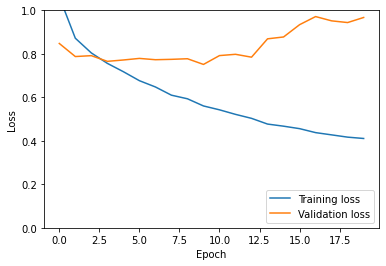

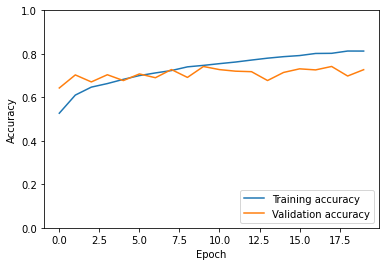

prediction =>  [9258 4030 2992 2463 1757]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,8356,1049,329,16,0
1,677,2747,245,31,0
2,207,205,2032,154,2
3,18,29,384,2148,46
4,0,0,2,114,1709


              precision    recall  f1-score   support

      Crop 0       0.90      0.86      0.88      9750
      Crop 1       0.68      0.74      0.71      3700
      Crop 2       0.68      0.78      0.73      2600
      Crop 3       0.87      0.82      0.84      2625
      Crop 4       0.97      0.94      0.95      1825

    accuracy                           0.83     20500
   macro avg       0.82      0.83      0.82     20500
weighted avg       0.84      0.83      0.83     20500

Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,369,17,4,0,0
1,18,129,1,0,0
2,1,0,102,1,0
3,0,0,13,92,0
4,0,0,0,4,69


              precision    recall  f1-score   support

      Crop 0       0.95      0.95      0.95       390
      Crop 1       0.88      0.87      0.88       148
      Crop 2       0.85      0.98      0.91       104
      Crop 3       0.95      0.88      0.91       105
      Crop 4       1.00      0.95      0.97        73

    accuracy                           0.93       820
   macro avg       0.93      0.92      0.92       820
weighted avg       0.93      0.93      0.93       820

prediction =>  [2239 1073  760  604  449]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1942,363,135,10,0
1,226,599,91,9,0
2,63,93,392,99,3
3,8,18,142,453,29
4,0,0,0,33,417


              precision    recall  f1-score   support

      Crop 0       0.87      0.79      0.83      2450
      Crop 1       0.56      0.65      0.60       925
      Crop 2       0.52      0.60      0.56       650
      Crop 3       0.75      0.70      0.72       650
      Crop 4       0.93      0.93      0.93       450

    accuracy                           0.74      5125
   macro avg       0.72      0.73      0.73      5125
weighted avg       0.76      0.74      0.75      5125

Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,86,10,2,0,0
1,6,28,3,0,0
2,0,3,20,3,0
3,0,0,3,23,0
4,0,0,0,1,17


              precision    recall  f1-score   support

      Crop 0       0.93      0.88      0.91        98
      Crop 1       0.68      0.76      0.72        37
      Crop 2       0.71      0.77      0.74        26
      Crop 3       0.85      0.88      0.87        26
      Crop 4       1.00      0.94      0.97        18

    accuracy                           0.85       205
   macro avg       0.84      0.85      0.84       205
weighted avg       0.86      0.85      0.85       205

prediction =>  [2388  633  449  643  887]
predictions file: output_tf/hKjHJdUcgqonKFpGUemcfA/hKjHJdUcgqonKFpGUemcfA_predict_c2_h1_test.csv
Distribution
--------
0: 109
1: 18
2: 11
3: 18
4: 44
Finished generating predictions to output_tf/hKjHJdUcgqonKFpGUemcfA/hKjHJdUcgqonKFpGUemcfA_predict_c2_h1_test.csv


array([0, 0, 0, ..., 0, 0, 0])

In [19]:
model = get_model(1024, 128, 0.5)
run_trial("h1", model)

#### H2: 1024-128-5, d=0.25

* DNN Structure: 1024-128-5
* Dropout: 0.25
* Class weights: balanced

Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Output generated to: output_tf/KZSrCvBQ9Tpx3Fu38ESDhT
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)         

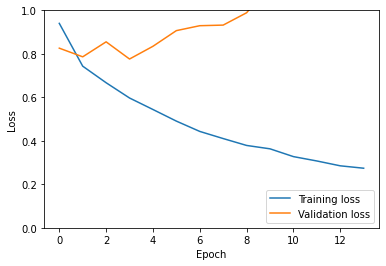

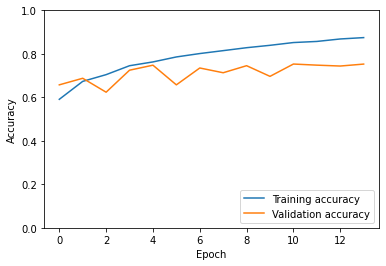

prediction =>  [9102 3729 2683 3083 1903]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,8153,1113,416,66,2
1,704,2457,392,145,2
2,216,144,1700,528,12
3,29,15,174,2289,118
4,0,0,1,55,1769


              precision    recall  f1-score   support

      Crop 0       0.90      0.84      0.86      9750
      Crop 1       0.66      0.66      0.66      3700
      Crop 2       0.63      0.65      0.64      2600
      Crop 3       0.74      0.87      0.80      2625
      Crop 4       0.93      0.97      0.95      1825

    accuracy                           0.80     20500
   macro avg       0.77      0.80      0.78     20500
weighted avg       0.80      0.80      0.80     20500

Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,367,20,3,0,0
1,23,113,8,4,0
2,3,0,87,14,0
3,0,0,4,100,1
4,0,0,0,0,73


              precision    recall  f1-score   support

      Crop 0       0.93      0.94      0.94       390
      Crop 1       0.85      0.76      0.80       148
      Crop 2       0.85      0.84      0.84       104
      Crop 3       0.85      0.95      0.90       105
      Crop 4       0.99      1.00      0.99        73

    accuracy                           0.90       820
   macro avg       0.89      0.90      0.90       820
weighted avg       0.90      0.90      0.90       820

prediction =>  [2265  936  661  757  506]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1938,324,158,28,2
1,241,537,112,35,0
2,74,63,320,187,6
3,12,12,71,489,66
4,0,0,0,18,432


              precision    recall  f1-score   support

      Crop 0       0.86      0.79      0.82      2450
      Crop 1       0.57      0.58      0.58       925
      Crop 2       0.48      0.49      0.49       650
      Crop 3       0.65      0.75      0.70       650
      Crop 4       0.85      0.96      0.90       450

    accuracy                           0.73      5125
   macro avg       0.68      0.72      0.70      5125
weighted avg       0.73      0.73      0.73      5125

Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,88,9,1,0,0
1,8,26,2,1,0
2,1,1,17,7,0
3,0,0,3,22,1
4,0,0,0,0,18


              precision    recall  f1-score   support

      Crop 0       0.91      0.90      0.90        98
      Crop 1       0.72      0.70      0.71        37
      Crop 2       0.74      0.65      0.69        26
      Crop 3       0.73      0.85      0.79        26
      Crop 4       0.95      1.00      0.97        18

    accuracy                           0.83       205
   macro avg       0.81      0.82      0.81       205
weighted avg       0.83      0.83      0.83       205

prediction =>  [2214  462  604  764  956]
predictions file: output_tf/KZSrCvBQ9Tpx3Fu38ESDhT/KZSrCvBQ9Tpx3Fu38ESDhT_predict_c2_h2_test.csv
Distribution
--------
0: 104
1: 11
2: 19
3: 24
4: 42
Finished generating predictions to output_tf/KZSrCvBQ9Tpx3Fu38ESDhT/KZSrCvBQ9Tpx3Fu38ESDhT_predict_c2_h2_test.csv


array([2, 0, 0, ..., 0, 0, 0])

In [20]:
model = get_model(1024, 128, 0.25)
run_trial("h2", model)

#### H3: 1024-128-5, d=0.1

* DNN Structure: 1024-128-5
* Dropout: 0.1
* Class weights: balanced

Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Output generated to: output_tf/bmmXUZ9AoRLzv2zsi5QtUv
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)         

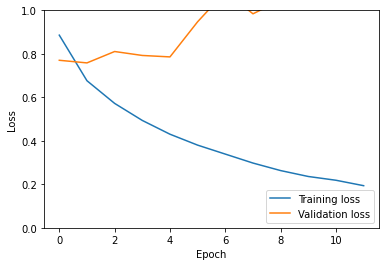

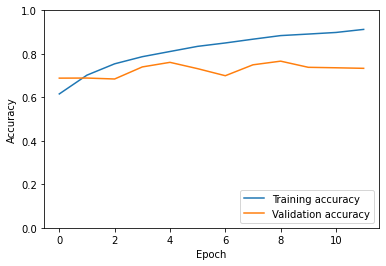

prediction =>  [8249 2547 4787 3222 1695]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,7293,866,1419,172,0
1,844,1649,1061,144,2
2,105,28,1997,467,3
3,7,4,307,2251,56
4,0,0,3,188,1634


              precision    recall  f1-score   support

      Crop 0       0.88      0.75      0.81      9750
      Crop 1       0.65      0.45      0.53      3700
      Crop 2       0.42      0.77      0.54      2600
      Crop 3       0.70      0.86      0.77      2625
      Crop 4       0.96      0.90      0.93      1825

    accuracy                           0.72     20500
   macro avg       0.72      0.74      0.72     20500
weighted avg       0.77      0.72      0.73     20500

Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,343,18,28,1,0
1,32,72,43,1,0
2,1,0,91,12,0
3,0,0,8,97,0
4,0,0,0,7,66


              precision    recall  f1-score   support

      Crop 0       0.91      0.88      0.90       390
      Crop 1       0.80      0.49      0.61       148
      Crop 2       0.54      0.88      0.66       104
      Crop 3       0.82      0.92      0.87       105
      Crop 4       1.00      0.90      0.95        73

    accuracy                           0.82       820
   macro avg       0.81      0.81      0.80       820
weighted avg       0.84      0.82      0.82       820

prediction =>  [1935  667 1281  829  413]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1743,192,453,62,0
1,163,454,281,27,0
2,25,16,436,173,0
3,4,5,110,507,24
4,0,0,1,60,389


              precision    recall  f1-score   support

      Crop 0       0.90      0.71      0.79      2450
      Crop 1       0.68      0.49      0.57       925
      Crop 2       0.34      0.67      0.45       650
      Crop 3       0.61      0.78      0.69       650
      Crop 4       0.94      0.86      0.90       450

    accuracy                           0.69      5125
   macro avg       0.70      0.70      0.68      5125
weighted avg       0.76      0.69      0.71      5125

Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,80,6,11,1,0
1,8,18,10,1,0
2,0,0,20,6,0
3,0,0,3,23,0
4,0,0,0,1,17


              precision    recall  f1-score   support

      Crop 0       0.91      0.82      0.86        98
      Crop 1       0.75      0.49      0.59        37
      Crop 2       0.45      0.77      0.57        26
      Crop 3       0.72      0.88      0.79        26
      Crop 4       1.00      0.94      0.97        18

    accuracy                           0.77       205
   macro avg       0.77      0.78      0.76       205
weighted avg       0.81      0.77      0.78       205

prediction =>  [1710  444 1058 1081  707]
predictions file: output_tf/bmmXUZ9AoRLzv2zsi5QtUv/bmmXUZ9AoRLzv2zsi5QtUv_predict_c2_h3_test.csv
Distribution
--------
0: 76
1: 10
2: 46
3: 38
4: 30
Finished generating predictions to output_tf/bmmXUZ9AoRLzv2zsi5QtUv/bmmXUZ9AoRLzv2zsi5QtUv_predict_c2_h3_test.csv


array([2, 0, 0, ..., 0, 0, 0])

In [21]:
model = get_model(1024, 128, 0.1)
run_trial("h3", model)

#### H4: 2048-256-5

* DNN Structure: 2048-256-5
* Dropout: 0.5
* Class weights: balanced
* Batch normalization: no


Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Output generated to: output_tf/iMkSHN4Z8jLq5EycP7FZga
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 2048)         

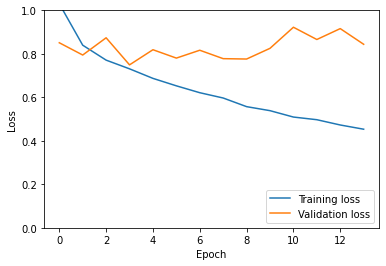

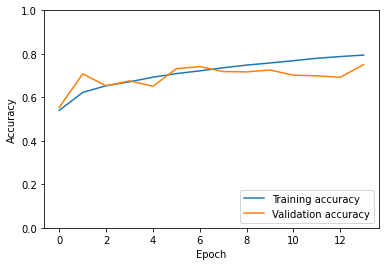

prediction =>  [7409 5071 3304 2956 1760]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,6688,2283,716,63,0
1,514,2497,576,112,1
2,201,264,1675,456,4
3,6,27,333,2176,83
4,0,0,4,149,1672


              precision    recall  f1-score   support

      Crop 0       0.90      0.69      0.78      9750
      Crop 1       0.49      0.67      0.57      3700
      Crop 2       0.51      0.64      0.57      2600
      Crop 3       0.74      0.83      0.78      2625
      Crop 4       0.95      0.92      0.93      1825

    accuracy                           0.72     20500
   macro avg       0.72      0.75      0.73     20500
weighted avg       0.76      0.72      0.73     20500

Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,296,77,17,0,0
1,12,114,22,0,0
2,4,3,81,16,0
3,0,0,10,95,0
4,0,0,0,4,69


              precision    recall  f1-score   support

      Crop 0       0.95      0.76      0.84       390
      Crop 1       0.59      0.77      0.67       148
      Crop 2       0.62      0.78      0.69       104
      Crop 3       0.83      0.90      0.86       105
      Crop 4       1.00      0.95      0.97        73

    accuracy                           0.80       820
   macro avg       0.80      0.83      0.81       820
weighted avg       0.83      0.80      0.81       820

prediction =>  [1722 1336  851  769  447]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1560,621,233,36,0
1,115,638,144,28,0
2,44,64,365,176,1
3,3,13,109,490,35
4,0,0,0,39,411


              precision    recall  f1-score   support

      Crop 0       0.91      0.64      0.75      2450
      Crop 1       0.48      0.69      0.56       925
      Crop 2       0.43      0.56      0.49       650
      Crop 3       0.64      0.75      0.69       650
      Crop 4       0.92      0.91      0.92       450

    accuracy                           0.68      5125
   macro avg       0.67      0.71      0.68      5125
weighted avg       0.74      0.68      0.69      5125

Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,72,20,5,1,0
1,4,30,2,1,0
2,1,1,16,8,0
3,0,0,3,22,1
4,0,0,0,1,17


              precision    recall  f1-score   support

      Crop 0       0.94      0.73      0.82        98
      Crop 1       0.59      0.81      0.68        37
      Crop 2       0.62      0.62      0.62        26
      Crop 3       0.67      0.85      0.75        26
      Crop 4       0.94      0.94      0.94        18

    accuracy                           0.77       205
   macro avg       0.75      0.79      0.76       205
weighted avg       0.80      0.77      0.77       205

prediction =>  [1783  885  661  850  821]
predictions file: output_tf/iMkSHN4Z8jLq5EycP7FZga/iMkSHN4Z8jLq5EycP7FZga_predict_c2_h4_test.csv
Distribution
--------
0: 74
1: 39
2: 21
3: 26
4: 40
Finished generating predictions to output_tf/iMkSHN4Z8jLq5EycP7FZga/iMkSHN4Z8jLq5EycP7FZga_predict_c2_h4_test.csv


array([2, 0, 0, ..., 0, 0, 0])

In [22]:
model = get_model(2048, 256, 0.5)
run_trial("h4", model)

#### H5: 512-64-5

* DNN Structure: 512-64-5
* Dropout: 0.5
* Class weights: balanced


Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Output generated to: output_tf/4qKQp9uUQykpHiLS4qbXxB
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)          

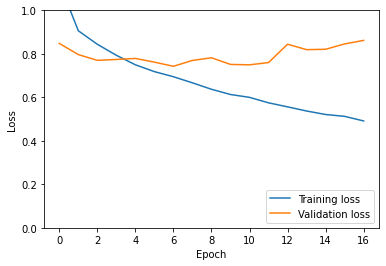

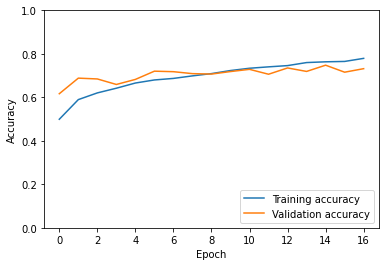

prediction =>  [9015 3753 3465 2347 1920]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,7877,1257,594,22,0
1,904,2262,477,57,0
2,222,213,1906,252,7
3,12,21,484,1938,170
4,0,0,4,78,1743


              precision    recall  f1-score   support

      Crop 0       0.87      0.81      0.84      9750
      Crop 1       0.60      0.61      0.61      3700
      Crop 2       0.55      0.73      0.63      2600
      Crop 3       0.83      0.74      0.78      2625
      Crop 4       0.91      0.96      0.93      1825

    accuracy                           0.77     20500
   macro avg       0.75      0.77      0.76     20500
weighted avg       0.78      0.77      0.77     20500

Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,356,25,9,0,0
1,34,101,13,0,0
2,2,2,96,4,0
3,0,0,13,87,5
4,0,0,0,0,73


              precision    recall  f1-score   support

      Crop 0       0.91      0.91      0.91       390
      Crop 1       0.79      0.68      0.73       148
      Crop 2       0.73      0.92      0.82       104
      Crop 3       0.96      0.83      0.89       105
      Crop 4       0.94      1.00      0.97        73

    accuracy                           0.87       820
   macro avg       0.86      0.87      0.86       820
weighted avg       0.87      0.87      0.87       820

prediction =>  [2145  988  893  608  491]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1872,345,219,14,0
1,218,565,125,17,0
2,50,65,397,133,5
3,5,13,152,420,60
4,0,0,0,24,426


              precision    recall  f1-score   support

      Crop 0       0.87      0.76      0.81      2450
      Crop 1       0.57      0.61      0.59       925
      Crop 2       0.44      0.61      0.51       650
      Crop 3       0.69      0.65      0.67       650
      Crop 4       0.87      0.95      0.91       450

    accuracy                           0.72      5125
   macro avg       0.69      0.72      0.70      5125
weighted avg       0.74      0.72      0.73      5125

Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,86,8,4,0,0
1,9,25,3,0,0
2,1,1,19,5,0
3,0,0,3,22,1
4,0,0,0,1,17


              precision    recall  f1-score   support

      Crop 0       0.90      0.88      0.89        98
      Crop 1       0.74      0.68      0.70        37
      Crop 2       0.66      0.73      0.69        26
      Crop 3       0.79      0.85      0.81        26
      Crop 4       0.94      0.94      0.94        18

    accuracy                           0.82       205
   macro avg       0.80      0.81      0.81       205
weighted avg       0.83      0.82      0.82       205

prediction =>  [2185  665  634  479 1037]
predictions file: output_tf/4qKQp9uUQykpHiLS4qbXxB/4qKQp9uUQykpHiLS4qbXxB_predict_c2_h5_test.csv
Distribution
--------
0: 96
1: 21
2: 25
3: 11
4: 47
Finished generating predictions to output_tf/4qKQp9uUQykpHiLS4qbXxB/4qKQp9uUQykpHiLS4qbXxB_predict_c2_h5_test.csv


array([2, 0, 0, ..., 0, 0, 0])

In [23]:
model = get_model(512, 64, 0.5)
run_trial("h5", model)

#### H6: 512-128-5

* DNN Structure: 512-128-5
* Dropout: 0.5
* Class weights: balanced

Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Output generated to: output_tf/6Sfvafx9GnD7qH7HFXoy5B
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)          

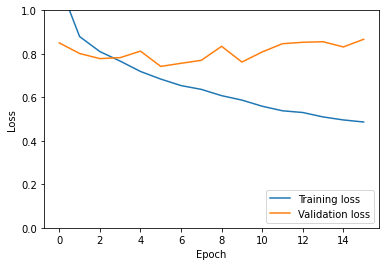

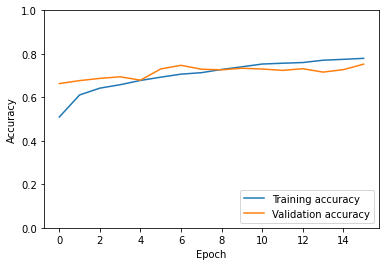

prediction =>  [9451 2847 3623 2843 1736]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,8167,774,750,59,0
1,1063,1939,616,82,0
2,207,121,1904,361,7
3,14,13,348,2184,66
4,0,0,5,157,1663


              precision    recall  f1-score   support

      Crop 0       0.86      0.84      0.85      9750
      Crop 1       0.68      0.52      0.59      3700
      Crop 2       0.53      0.73      0.61      2600
      Crop 3       0.77      0.83      0.80      2625
      Crop 4       0.96      0.91      0.93      1825

    accuracy                           0.77     20500
   macro avg       0.76      0.77      0.76     20500
weighted avg       0.78      0.77      0.77     20500

Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,370,12,8,0,0
1,45,81,22,0,0
2,4,1,93,6,0
3,0,0,11,93,1
4,0,0,0,4,69


              precision    recall  f1-score   support

      Crop 0       0.88      0.95      0.91       390
      Crop 1       0.86      0.55      0.67       148
      Crop 2       0.69      0.89      0.78       104
      Crop 3       0.90      0.89      0.89       105
      Crop 4       0.99      0.95      0.97        73

    accuracy                           0.86       820
   macro avg       0.87      0.84      0.84       820
weighted avg       0.87      0.86      0.86       820

prediction =>  [2248  778  923  742  434]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1956,214,261,19,0
1,244,505,155,21,0
2,41,54,388,167,0
3,7,5,119,490,29
4,0,0,0,45,405


              precision    recall  f1-score   support

      Crop 0       0.87      0.80      0.83      2450
      Crop 1       0.65      0.55      0.59       925
      Crop 2       0.42      0.60      0.49       650
      Crop 3       0.66      0.75      0.70       650
      Crop 4       0.93      0.90      0.92       450

    accuracy                           0.73      5125
   macro avg       0.71      0.72      0.71      5125
weighted avg       0.75      0.73      0.74      5125

Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,91,3,4,0,0
1,11,23,3,0,0
2,0,2,18,6,0
3,0,0,3,22,1
4,0,0,0,1,17


              precision    recall  f1-score   support

      Crop 0       0.89      0.93      0.91        98
      Crop 1       0.82      0.62      0.71        37
      Crop 2       0.64      0.69      0.67        26
      Crop 3       0.76      0.85      0.80        26
      Crop 4       0.94      0.94      0.94        18

    accuracy                           0.83       205
   macro avg       0.81      0.81      0.81       205
weighted avg       0.84      0.83      0.83       205

prediction =>  [2136  443  771  808  842]
predictions file: output_tf/6Sfvafx9GnD7qH7HFXoy5B/6Sfvafx9GnD7qH7HFXoy5B_predict_c2_h6_test.csv
Distribution
--------
0: 95
1: 12
2: 26
3: 28
4: 39
Finished generating predictions to output_tf/6Sfvafx9GnD7qH7HFXoy5B/6Sfvafx9GnD7qH7HFXoy5B_predict_c2_h6_test.csv


array([2, 2, 0, ..., 0, 0, 0])

In [24]:
model = get_model(512, 128, 0.5)
run_trial("h6", model)

#### H7: 512-256-5

* DNN Structure: 512-256-5
* Dropout: 0.5
* Class weights: balanced

Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Output generated to: output_tf/9KvcAUn4RJDVGe7WReGaoo
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)          

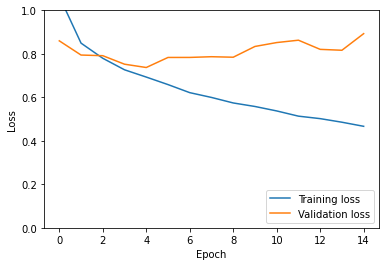

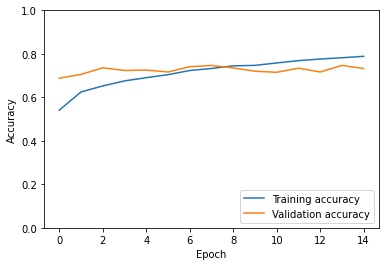

prediction =>  [8980 3929 2983 2759 1849]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,7898,1246,533,73,0
1,851,2363,384,101,1
2,217,268,1749,360,6
3,14,52,315,2125,119
4,0,0,2,100,1723


              precision    recall  f1-score   support

      Crop 0       0.88      0.81      0.84      9750
      Crop 1       0.60      0.64      0.62      3700
      Crop 2       0.59      0.67      0.63      2600
      Crop 3       0.77      0.81      0.79      2625
      Crop 4       0.93      0.94      0.94      1825

    accuracy                           0.77     20500
   macro avg       0.75      0.78      0.76     20500
weighted avg       0.78      0.77      0.78     20500

Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,360,25,5,0,0
1,32,103,13,0,0
2,3,6,87,8,0
3,0,0,11,92,2
4,0,0,0,3,70


              precision    recall  f1-score   support

      Crop 0       0.91      0.92      0.92       390
      Crop 1       0.77      0.70      0.73       148
      Crop 2       0.75      0.84      0.79       104
      Crop 3       0.89      0.88      0.88       105
      Crop 4       0.97      0.96      0.97        73

    accuracy                           0.87       820
   macro avg       0.86      0.86      0.86       820
weighted avg       0.87      0.87      0.87       820

prediction =>  [2125 1062  750  728  460]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1880,330,211,29,0
1,193,610,103,19,0
2,43,102,331,170,4
3,9,20,105,479,37
4,0,0,0,31,419


              precision    recall  f1-score   support

      Crop 0       0.88      0.77      0.82      2450
      Crop 1       0.57      0.66      0.61       925
      Crop 2       0.44      0.51      0.47       650
      Crop 3       0.66      0.74      0.70       650
      Crop 4       0.91      0.93      0.92       450

    accuracy                           0.73      5125
   macro avg       0.69      0.72      0.70      5125
weighted avg       0.75      0.73      0.73      5125

Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,87,8,3,0,0
1,8,26,3,0,0
2,0,4,17,5,0
3,0,1,3,21,1
4,0,0,0,1,17


              precision    recall  f1-score   support

      Crop 0       0.92      0.89      0.90        98
      Crop 1       0.67      0.70      0.68        37
      Crop 2       0.65      0.65      0.65        26
      Crop 3       0.78      0.81      0.79        26
      Crop 4       0.94      0.94      0.94        18

    accuracy                           0.82       205
   macro avg       0.79      0.80      0.80       205
weighted avg       0.82      0.82      0.82       205

prediction =>  [1934  815  608  675  968]
predictions file: output_tf/9KvcAUn4RJDVGe7WReGaoo/9KvcAUn4RJDVGe7WReGaoo_predict_c2_h7_test.csv
Distribution
--------
0: 85
1: 34
2: 18
3: 18
4: 45
Finished generating predictions to output_tf/9KvcAUn4RJDVGe7WReGaoo/9KvcAUn4RJDVGe7WReGaoo_predict_c2_h7_test.csv


array([2, 0, 0, ..., 0, 0, 0])

In [25]:
model = get_model(512, 256, 0.5)
run_trial("h7", model)

#### H8: 1024-256-5

* DNN Structure: 1024-256-5
* Dropout: 0.5
* Class weights: balanced

Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Output generated to: output_tf/SVVYzD6L2PCggvGqeTWodf
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1024)         

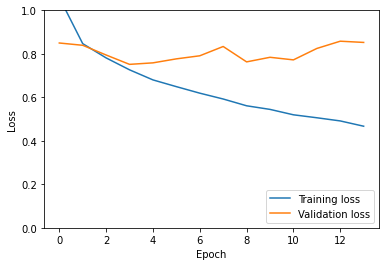

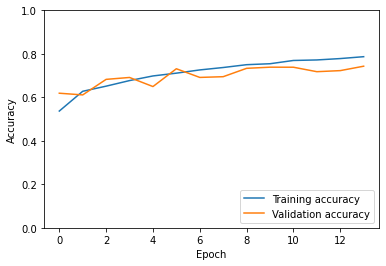

prediction =>  [8069 3850 3851 3005 1725]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,7225,1414,1048,63,0
1,691,2236,648,125,0
2,145,172,1830,444,9
3,8,28,322,2187,80
4,0,0,3,186,1636


              precision    recall  f1-score   support

      Crop 0       0.90      0.74      0.81      9750
      Crop 1       0.58      0.60      0.59      3700
      Crop 2       0.48      0.70      0.57      2600
      Crop 3       0.73      0.83      0.78      2625
      Crop 4       0.95      0.90      0.92      1825

    accuracy                           0.74     20500
   macro avg       0.73      0.76      0.73     20500
weighted avg       0.77      0.74      0.75     20500

Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,332,38,20,0,0
1,22,103,22,1,0
2,2,3,85,14,0
3,0,0,9,96,0
4,0,0,0,7,66


              precision    recall  f1-score   support

      Crop 0       0.93      0.85      0.89       390
      Crop 1       0.72      0.70      0.71       148
      Crop 2       0.62      0.82      0.71       104
      Crop 3       0.81      0.91      0.86       105
      Crop 4       1.00      0.90      0.95        73

    accuracy                           0.83       820
   macro avg       0.82      0.84      0.82       820
weighted avg       0.85      0.83      0.84       820

prediction =>  [1912 1008  999  768  438]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1710,367,347,26,0
1,165,566,166,28,0
2,34,64,373,179,0
3,3,11,113,489,34
4,0,0,0,46,404


              precision    recall  f1-score   support

      Crop 0       0.89      0.70      0.78      2450
      Crop 1       0.56      0.61      0.59       925
      Crop 2       0.37      0.57      0.45       650
      Crop 3       0.64      0.75      0.69       650
      Crop 4       0.92      0.90      0.91       450

    accuracy                           0.69      5125
   macro avg       0.68      0.71      0.68      5125
weighted avg       0.74      0.69      0.71      5125

Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,78,10,10,0,0
1,7,25,4,1,0
2,0,2,16,8,0
3,0,0,3,22,1
4,0,0,0,1,17


              precision    recall  f1-score   support

      Crop 0       0.92      0.80      0.85        98
      Crop 1       0.68      0.68      0.68        37
      Crop 2       0.48      0.62      0.54        26
      Crop 3       0.69      0.85      0.76        26
      Crop 4       0.94      0.94      0.94        18

    accuracy                           0.77       205
   macro avg       0.74      0.78      0.75       205
weighted avg       0.79      0.77      0.78       205

prediction =>  [1900  669  804  741  886]
predictions file: output_tf/SVVYzD6L2PCggvGqeTWodf/SVVYzD6L2PCggvGqeTWodf_predict_c2_h8_test.csv
Distribution
--------
0: 86
1: 24
2: 26
3: 25
4: 39
Finished generating predictions to output_tf/SVVYzD6L2PCggvGqeTWodf/SVVYzD6L2PCggvGqeTWodf_predict_c2_h8_test.csv


array([2, 0, 0, ..., 0, 0, 0])

In [26]:
model = get_model(1024, 256, 0.5)
run_trial("h8", model)

#### Summary: Best hyperparameters

In [27]:
raise Exception
optimal_n1 = 1024
optimal_n2 = 128
optimal_d = 0.5


Exception: 

## Train with all data and optimal hyperparameters

In [ ]:
model = get_model(optimal_n1, optimal_n2, optimal_d)
run_trial("a1", model, group=all_train_data_group(), num_epochs=25)
